In [19]:
import intake
import matplotlib.pyplot as plt
import pandas as pd

from fresca_catalog import search_catalog_variables, filter_catalog


catalog = intake.open_catalog('full_catalog.yml')

# These are different column names for "time" in different datasets.
# The list below is used to merge the dataset times together.
# It must be updated using the metadata from each dataset.
# TODO: Is there a better way to do this?
TIME_COL_NAMES = ['time', 'datetime', 'Date_UTC', 'UTCDate']

temperature_variables = search_catalog_variables(catalog, 'temp')
# TODO: Can I search for datasets that have both 'temp' AND 'time'?

my_catalog = filter_catalog(
    catalog,
    variables=temperature_variables,
    time_range=('2020-12-01T13:23:00Z', '2025-01-17T23:54:00Z'),
    # bbox=(70.0, 20.0, 90.0, 40.0)
)

print(f"Datasets included: {my_catalog}")

Datasets included: Catalog
 named datasets: ['CRCP_Carbonate_Chemistry_Atlantic', 'SFER_data']


In [20]:
# print dataset metadata (Note the different "time" column names.
for dataset_name in my_catalog:
    print(my_catalog[dataset_name].metadata)
    

{'maxLatitude': 28.7841, 'maxLongitude': 85.0221, 'maxTime': '2024-11-17T23:54:00Z', 'minLatitude': 24.3952, 'minLongitude': 80.0442, 'minTime': '2014-12-01T13:23:00Z', 'variables': ['keyfield', 'cruise_id', 'year', 'month', 'day', 'time', 'datetime', 'lat_deg', 'lat_min', 'lat_dec', 'lon_deg', 'lon_min', 'lon_dec', 'station', 'station_type', 'depth', 'depth_class', 'depth_order', 'cast', 'nisk_start', 'nisk_end', 'net_tow_500', 'net_tow_200', 'net_tow_64', 'plank_image', 'insitu_rrs', 'temp', 'sal', 'o2_ctd', 'o2_disc', 'nh4', 'no2', 'no3', 'no3_no2', 'po4', 'si', 'avg_chl_a', 'avg_phaeo', 'notes']}
{'datasetID': 'CRCP_Carbonate_Chemistry_Atlantic', 'griddap': '', 'info_url': 'https://www.ncei.noaa.gov/erddap/info/CRCP_Carbonate_Chemistry_Atlantic/index.csv', 'institution': 'Coral Reef Conservation Program', 'maxLatitude': 27.92243, 'maxLongitude': -64.47317, 'maxTime': '2022-12-18T15:53:00Z', 'minLatitude': 17.63673, 'minLongitude': -93.823, 'minTime': '2010-03-08T12:26:00Z', 'summar

In [29]:

# --- Read, clean, and merge data ---
# TODO: can this be worked into a function in the package?
dataframes = []

for dataset_name in my_catalog:
    temporary_df = my_catalog[dataset_name].read()
    
    # Identify the time column
    time_column = next((col for col in TIME_COL_NAMES if col in temporary_df.columns), None)
    if not time_column:
        print(f"No time column found in dataset '{dataset_name}'. Skipping.")
        continue

    # Convert the identified time column to datetime
    temporary_df['time'] = pd.to_datetime(temporary_df[time_column], errors='coerce')
    temporary_df = temporary_df.dropna(subset=['time'])  # Remove invalid dates
    
    # Identify candidate temperature columns (allowing partial matches)
    # TODO: Why does this need a partial match?
    #       Because my_catalog[dataset_name].metadata shows Temperature_C as the column name, 
    #       but when I print the head() of the df the column name shows Temperature_C (degrees_Celsius). 
    #       Why does the metadata not match the data returned by read()?
    #       Should this be fixed or should this partial matching be included in the package?
    candidate_vars = [
        col for col in temporary_df.columns
        if any(temp_var in col for temp_var in temperature_variables)
    ]

    # --- Debugging Step 1: Print candidate variables ---
    print(f"\nDataset: {dataset_name}")
    print(f"Candidate temperature variables found: {candidate_vars}")
    
    # --- Debugging Step 2: Display the first few rows for inspection ---
    print("Sample data:")
    print(temporary_df[candidate_vars].head()) if candidate_vars else print("No candidate temperature variables found.")

    # Convert candidates to numeric if possible
    numeric_temp_vars = []
    for var in candidate_vars:
        temporary_df[var] = pd.to_numeric(temporary_df[var], errors='coerce')

        # --- Debugging Step 3: Check data type and NaN count after conversion ---
        print(f"Variable '{var}' - Non-NaN Count: {temporary_df[var].notna().sum()}, Data Type: {temporary_df[var].dtype}")
        
        if not temporary_df[var].isna().all():
            numeric_temp_vars.append(var)
    
    if not numeric_temp_vars:
        print(f"⚠️ No valid numeric temperature variable found in dataset '{dataset_name}'. Skipping.\n")
        continue

    # Merge temperature columns
    if len(numeric_temp_vars) > 1:
        temporary_df['temperature'] = temporary_df[numeric_temp_vars].mean(axis=1)
    else:
        temporary_df = temporary_df.rename(columns={numeric_temp_vars[0]: 'temperature'})
    
    # Drop NaN values in 'temperature'
    temporary_df = temporary_df.dropna(subset=['temperature'])
    
    # Add dataset identifier
    temporary_df['dataset'] = dataset_name
    
    # Keep only relevant columns
    temporary_df = temporary_df[['time', 'dataset', 'temperature']]
    
    dataframes.append(temporary_df)

# Combine DataFrames
if dataframes:
    df = pd.concat(dataframes, ignore_index=True)
else:
    raise ValueError("No datasets with valid numeric temperature data were found.")

# Ensure 'time' is the index
df.set_index('time', inplace=True)

/tmp/ipykernel_466629/954992726.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temporary_df['time'] = pd.to_datetime(temporary_df[time_column], errors='coerce')



Dataset: SFER_data
Candidate temperature variables found: ['temp']
Sample data:
     temp
0  23.528
1  24.778
2  25.328
3  21.325
4  24.709
Variable 'temp' - Non-NaN Count: 8467, Data Type: float64

Dataset: CRCP_Carbonate_Chemistry_Atlantic
Candidate temperature variables found: ['Temperature_C (degrees_Celsius)']
Sample data:
   Temperature_C (degrees_Celsius)
0                         20.43233
1                         21.57933
2                         18.83900
3                         18.82450
4                         20.77000
Variable 'Temperature_C (degrees_Celsius)' - Non-NaN Count: 4969, Data Type: float64



Dataset: CRCP_Carbonate_Chemistry_Atlantic
dataset         object
temperature    float64
dtype: object

Dataset: SFER_data
dataset         object
temperature    float64
dtype: object


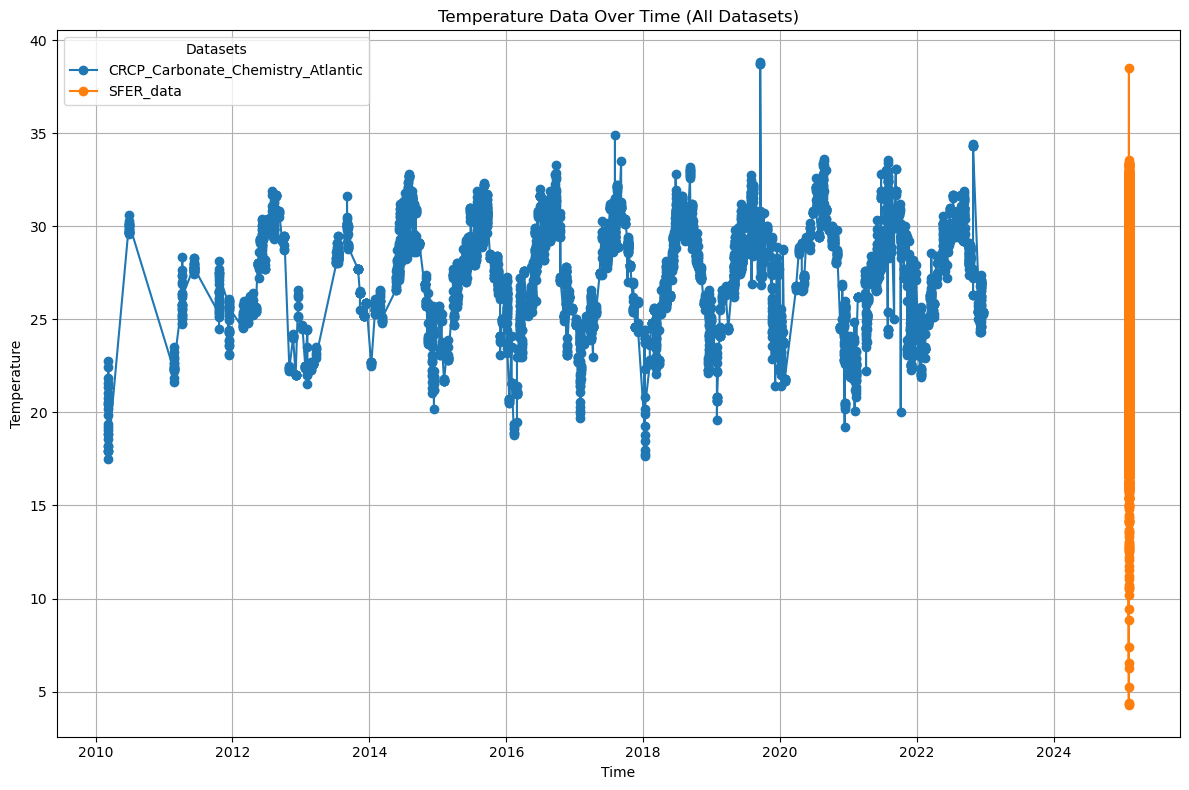

In [31]:
# --- Plot raw temperature data for all datasets on a single plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Larger figure for clarity

# Loop through each dataset and plot its raw temperature data
for dataset_name, group in df.groupby('dataset'):
    print(f"\nDataset: {dataset_name}")
    print(group.dtypes)  # Verify data types

    # Plot raw temperature data without aggregation
    plt.plot(group.index, group['temperature'], marker='o', linestyle='-', label=dataset_name)

# Add plot details
plt.title('Temperature Data Over Time (All Datasets)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend(title='Datasets')  # Legend to identify datasets
plt.grid(True)
plt.tight_layout()
plt.show()
